## Pythagorean Pentatonic Scales

This is an example of using PyTuning in a Jupyter notebook environment. It is an exploration of
possible pentatonic scales drawn from Pythagorean tuning.

### Imports

In [1]:
from __future__ import division, print_function

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sympy as sp

from pytuning.scales.pythagorean import create_pythagorean_scale
from pytuning.scales.edo import create_edo_scale
from pytuning.utilities import ratio_to_cents, mask_scale, distinct_intervals, compare_two_scales, \
    note_number_to_freq
from pytuning.metrics import sum_p_q_for_all_intervals
from pytuning.tuning_tables import create_scala_tuning, create_timidity_tuning
from pytuning.scale_creation import find_best_modes
from pytuning.visualizations import consonance_matrix

%matplotlib inline
sns.set()
plt.ioff()

sp.init_printing(use_unicode=True)

from IPython.display import display

import pprint
pp = pprint.PrettyPrinter(indent=2)

The Pythagorean scale is created by walking up a circle of perfect fifths. However, one can also move *down* a fourth, and this creates some ambiguity to what the scale is. So, for example, if we just use up fifths:

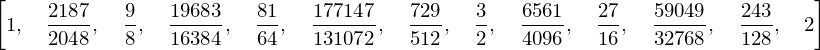

In [2]:
scale = create_pythagorean_scale(number_down_fifths=0)
scale

On the other hand, if we just use *down* fifths:

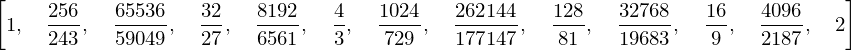

In [3]:
scale = create_pythagorean_scale(number_down_fifths=11)
scale

(In the Wikipedia article the scale presented looks like):

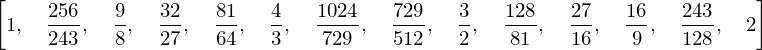

In [4]:
create_pythagorean_scale(scale_size=13, number_down_fifths=6)

(with both the augmented fourth and diminished fifth, which is why we set scale_size to 13.)

### The difference between up and down

Let's take a look at the two extremes, and see how much they differ

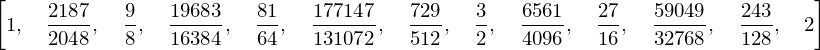

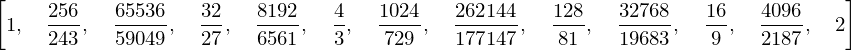

In [5]:
up_scale   = create_pythagorean_scale(number_down_fifths=0)
down_scale = create_pythagorean_scale(number_down_fifths=11)
display(up_scale)
display(down_scale)

Looking at the differences in the degrees, we see that all degrees differ from their siblings by the
same amount:

In [6]:
pp.pprint([ratio_to_cents(x) for x in np.array(up_scale) / np.array(down_scale)])

[ 0,
  23.4600103846490,
  23.4600103846490,
  23.4600103846490,
  23.4600103846490,
  23.4600103846490,
  23.4600103846490,
  23.4600103846490,
  23.4600103846490,
  23.4600103846490,
  23.4600103846490,
  23.4600103846490,
  0]


Rationally, this is $\frac{531441}{524288}$):

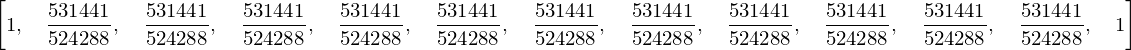

In [7]:
display([x for x in np.array(up_scale) / np.array(down_scale)])

(or, as a ratio:)

In [8]:
sp.Rational(531441,524288).evalf()

Looking at it this way, we have 12 different scales:

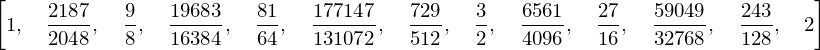

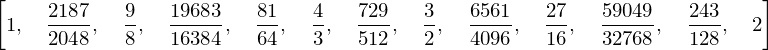

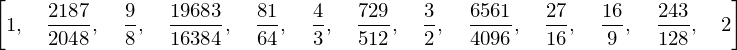

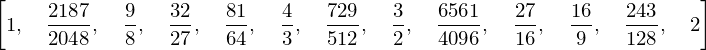

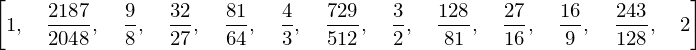

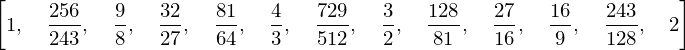

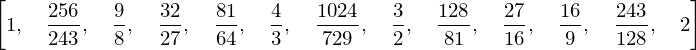

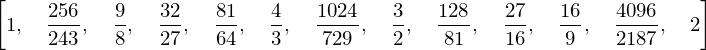

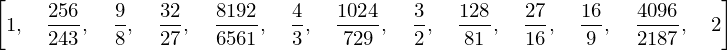

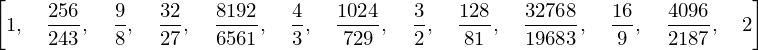

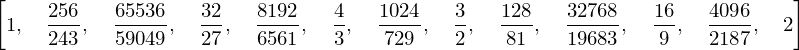

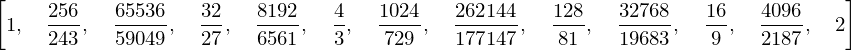

In [9]:
for x in range(12):
    display(create_pythagorean_scale(number_down_fifths=x))

### Consonance

Let's see if these scales vary in dissonance. For this we'll use the `sum_p_q_for_all_intervals` metric.

To find out we'll create `dict`, with the key as the number of down-facing fifths, and the value
the actual scale:

In [10]:
pythag_dict = {}
for x in range(12):
    pythag_dict[x] =  create_pythagorean_scale(number_down_fifths=x)

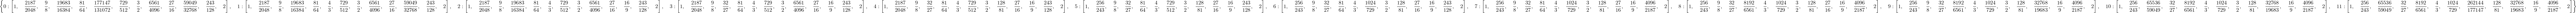

In [11]:
pythag_dict

Now map the metric

In [12]:
for key in pythag_dict:
    pythag_dict[key] = list(sum_p_q_for_all_intervals(pythag_dict[key]).values())[0]
    
pp.pprint(pythag_dict)

{ 0: 1092732,
  1: 1092732,
  2: 1092732,
  3: 1092732,
  4: 1092732,
  5: 1092732,
  6: 1092732,
  7: 1092732,
  8: 1092732,
  9: 1092732,
  10: 1092732,
  11: 1092732}


They all have the same rating.

But what happens if we just examine a single mode, say, one of the pentatonic scales? Let's take the Major
Pentatonic:

$$
\left[ 2, 2, 3, 2, 3 \right]
$$

and see.

Note that we hash the mode mask against all the possible Pythagorean scales, and because we're only taking
selected notes, we can at times have repetitions. The following function strips out those repetitions
(mode scales which are the same owing to the fact that there are no differences in the set of selected
tones):

In [13]:
def calculate_metric_with_mask(mask):
    all_scales = []
    pythag_dict = {}
    for x in range(12):
        try_scale = mask_scale(create_pythagorean_scale(number_down_fifths=x), mask)
        if try_scale not in all_scales:
            pythag_dict[x] =  try_scale
            all_scales.append(try_scale)

    metric_dict = {}
    for key in pythag_dict:
        metric_dict[key] = list(sum_p_q_for_all_intervals(pythag_dict[key]).values())[0]

    return pythag_dict, metric_dict

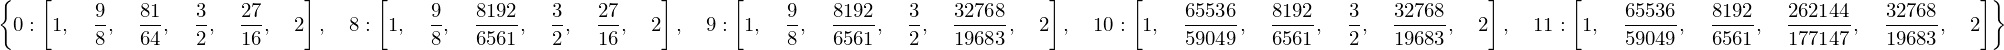

In [14]:
major_pentatonic_mask = (0,2,4,7,9,12)
scales, metrics = calculate_metric_with_mask(major_pentatonic_mask)
display(scales)
display(metrics)

The metric is smallest for scale 0:

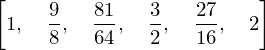

In [15]:
scales[0]

This is without doubt the one that the standard would produce:

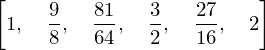

In [16]:
mask_scale(create_pythagorean_scale(), major_pentatonic_mask)

Let's try the same thing with the Minor pentatonic scale:

$$
\left[ 3, 2, 2, 3, 2 \right]
$$

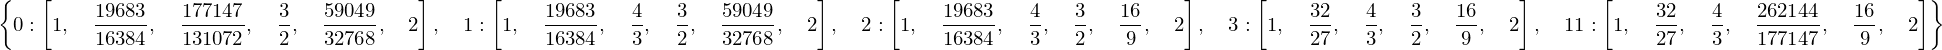

In [17]:
minor_pentatonic_mask = (0,3,5,7,10,12)
scales, metrics       = calculate_metric_with_mask(minor_pentatonic_mask)
display(scales)
display(metrics)

Minimized for 3:

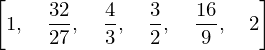

In [18]:
scales[3]

Again, the standard tuning:

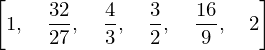

In [19]:
mask_scale(create_pythagorean_scale(), minor_pentatonic_mask)

Interestingly, both the minor and major scale have the same set of distinct intervals (which explains why the
metric was the same value):

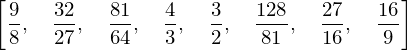

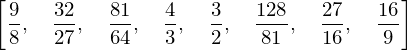

In [20]:
minor_pent = mask_scale(create_pythagorean_scale(), minor_pentatonic_mask)
major_pent = mask_scale(create_pythagorean_scale(), major_pentatonic_mask)
display(sorted(distinct_intervals(minor_pent)))
display(sorted(distinct_intervals(major_pent)))

### Comparison with 12-EDO

Let's compare these with the 12-TET equivalents

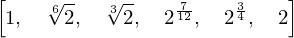

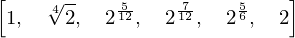

In [21]:
major_edo = mask_scale(create_edo_scale(12), major_pentatonic_mask)
minor_edo = mask_scale(create_edo_scale(12), minor_pentatonic_mask)
display(major_edo)
display(minor_edo)

In [22]:
print(compare_two_scales(minor_edo, minor_pent, title=['Minor EDO', 'Minor Pythagorean']))
print()
print(compare_two_scales(major_edo, major_pent, title=['Major EDO', 'Major Pythagorean']))

            Minor EDO     Minor Pythagorean
     Cents       Freq      Cents       Freq  Delta(Cents)
 =========  =========  =========  =========  ============
    0.0000   220.0000     0.0000   220.0000        0.0000
  300.0000   261.6256   294.1350   260.7407        5.8650
  500.0000   293.6648   498.0450   293.3333        1.9550
  700.0000   329.6276   701.9550   330.0000       -1.9550
 1000.0000   391.9954   996.0900   391.1111        3.9100
 1200.0000   440.0000  1200.0000   440.0000        0.0000
None

            Major EDO     Major Pythagorean
     Cents       Freq      Cents       Freq  Delta(Cents)
 =========  =========  =========  =========  ============
    0.0000   220.0000     0.0000   220.0000        0.0000
  200.0000   246.9417   203.9100   247.5000       -3.9100
  400.0000   277.1826   407.8200   278.4375       -7.8200
  700.0000   329.6276   701.9550   330.0000       -1.9550
  900.0000   369.9944   905.8650   371.2500       -5.8650
 1200.0000   440.0000  1200.0000   4

### Which Pentatonic Scales Sounds the Best?

Let's take the standard Pythagorean scale and perform a consonance search.

We'll use `find_best_modes()` and select five tones. We'll also set `num_scales` to `None` so that
all scales will be returned.

In [23]:
standard_pythag = create_pythagorean_scale()
mode_objects = find_best_modes(standard_pythag, 5, ['sum_p_q_for_all_intervals'], num_scales=None,
                              metric_function=sum_p_q_for_all_intervals)

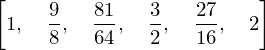

In [24]:
display(mode_objects[0]['scale'])

.... which looks a lot like the major pentatonic:

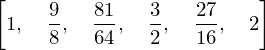

In [25]:
display(major_pent)

Let's look at the top few scales, to see if the minor is up there too....

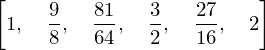

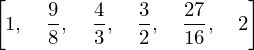

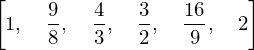

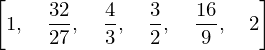

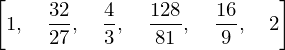

In [26]:
top_scales = [ x['scale'] for x in mode_objects][:5]
for s in top_scales:
    display(s)

It's number 4 on the list:

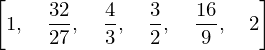

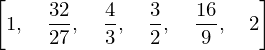

In [27]:
display(minor_pent)
display(mode_objects[3]['scale'])

But this is a bit misleading, as if we actually look at the scores, you'll see that the top five all have 
the same score:

In [28]:
display([x['sum_p_q_for_all_intervals'] for x in mode_objects][:26])

Thus by this metric the following scales are all equivalently "good":

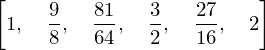

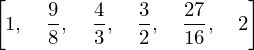

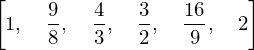

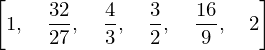

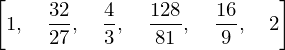

In [29]:
for x in range(5):
    display(mode_objects[x]['scale'])

Let's do a visualization of of one of the scale, the last one, for example:

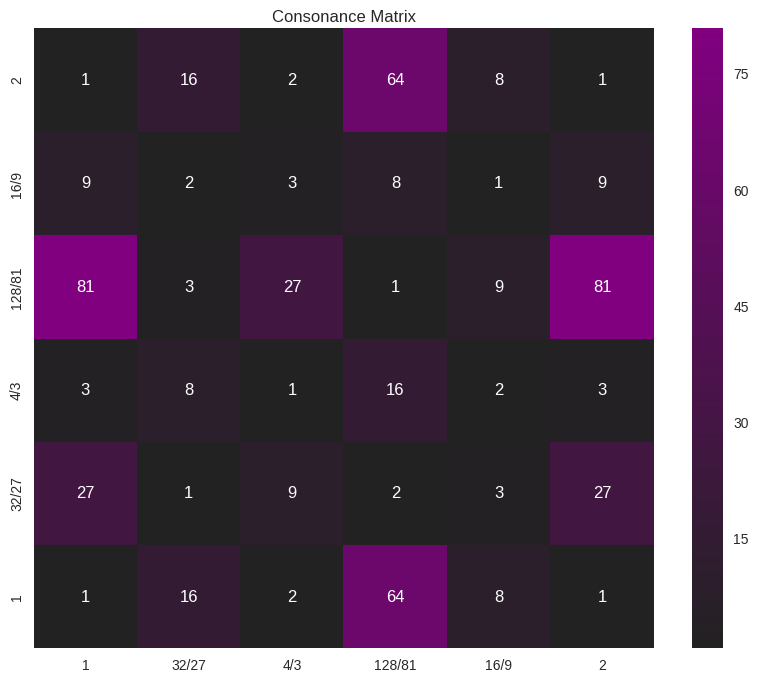

In [30]:
consonance_matrix(mode_objects[4]['scale'])

Interestingly, the scale patterns (the steps between adjacent degrees) for all five of these scales are
rotational permutations of one another:

In [31]:
for x in range(5):
    display(mode_objects[x]['steps'])

But owing to the fact that the scale itself is not equally tempered, the scales themselves are *not*.

If you wanted to open things up a bit, the next five have the same value too. (Note that including
10 scales in the list is somewhat arbitrary: the first five have the same metric, but the next *20* are
grouped together. Just taking 5 out of the 20 is arbitrary.)

So, the top 10 scales -- the first five of which fall into a consonance group, the second of which fall into their own group:

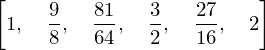

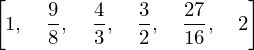

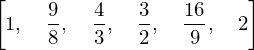

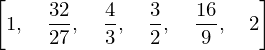

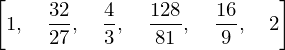

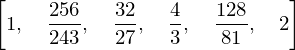

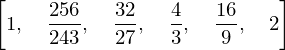

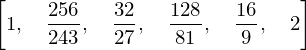

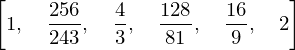

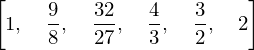

In [32]:
for x in range(10):
    display(mode_objects[x]['scale'])

### Tuning

For working with these tunings, the following function will take an index into the `mode_objects` data
structure and display several different tuning files for the resultant scale:

In [33]:
def create_tunings(index, mode_objects = mode_objects, reference_note = 69):
    reference_frequency = note_number_to_freq(reference_note, create_edo_scale(12))
    steps               = mode_objects[index]['steps']
    scale               = mode_objects[index]['scale']
    original_scale      = mode_objects[index]['original_scale']
    mode_steps          = mode_objects[index]['steps']
    mask                = mode_objects[index]['mask']
    metric               = mode_objects[index]['sum_p_q_for_all_intervals']
    em_spec = "set scale "  + str(tuple(mode_objects[10]['steps'])) + " %d" % reference_note
    timidity = create_timidity_tuning(scale, reference_note)
    
    print("*******************")
    print("Summary Information")
    print("*******************")
    print("Reference Note:      %d" % reference_note)
    print("Reference Frequency: %f" % reference_frequency)
    print("Metric:              %d" % metric)
    print("Mode Steps:          %s" % str(mode_steps))
    print("Mode Mask:           %s" % str(mask))
    print("")
    print("********")
    print("Tunings")
    print("********")
    
    print("\n***Emergent Tuning***\n")
    print(em_spec)
    print("\n***Scala Tuning***\n")
    print(create_scala_tuning(original_scale, "Pentatonic %d" % index))
    print("\n***Timidity Tuning***\n")
    print(timidity)
    

As an example, the 10th scale, referenced to C = 261.6 Hz:

In [34]:
create_tunings(9, reference_note=60)

*******************
Summary Information
*******************
Reference Note:      60
Reference Frequency: 261.625565
Metric:              1380
Mode Steps:          [2, 1, 2, 2, 5]
Mode Mask:           (0, 2, 3, 5, 7, 12)

********
Tunings
********

***Emergent Tuning***

set scale (2, 1, 2, 5, 2) 60

***Scala Tuning***

! Scale produced by pytuning. For tuning yoshimi or zynaddsubfx,
! only include the portion below the final '!'
!
Pentatonic 9
 12
!
256/243
9/8
32/27
81/64
4/3
1024/729
3/2
128/81
27/16
16/9
243/128
2/1

***Timidity Tuning***

# Timidity tuning table created by pytuning,
# call timidity with the -Z option to enable.
# Note reference: 60; Freq reference: 261.625565 Hz
64
72
76
85
96
128
144
151
170
192
255
287
303
341
383
511
575
606
681
766
1022
1150
1211
1363
1533
2044
2299
2422
2725
3066
4088
4599
4845
5451
6132
8176
9198
9690
10901
12264
16352
18396
19380
21802
24527
32703
36791
38759
43604
49055
65406
73582
77519
87209
98110
130813
147164
155037
174417
196219
261626